In [212]:
%reset -f
import os
import sys
import pathlib
# import argparse

sys.path.append('/home/psimmerl/mds_analysis')

import math
import numpy as np
import numba as nb
from math import ceil, floor

import pickle

# from src.helper_functions import alert, Table
# from src.histo_utilities import std_color_list as SCL

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
# from ROOT import TNtuple, TTree, TBranch, RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors

from src.helper_functions import alert, Table, weight_calc

# **************************** #
OUT_DIR = 'reports/weekly/2024-03-27'
LOCAL_OUT_DIR = '/home/psimmerl/mds_analysis'  # os.getcwd()

DATA_VERSION = '6'
LUMI = 23.02 * 1000
PI = rt.TMath.Pi()

LOCAL_DATA_DIR = '/home/psimmerl/mds_analysis/data'  # os.getcwd() + '/data/raw'
DATA_DIR = LOCAL_DATA_DIR#'TIER2' if 'caltech' in os.uname()[1] else 'LOCAL'
OUT_DIR = f'{LOCAL_OUT_DIR}/{OUT_DIR}'

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

ROOT_ERROR_LEVEL = 1001  # rt.kInfo + 1
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL

SCL = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

gc = []

# **************** #

TAG_CATEGORY = ('csccsc', 'cscdt')[0]
SIZE_VAR = TAG_CATEGORY[3:]


MET_CATEGORY = ('lt200', 'low', 'high')[1]
ABCD_DPHI = None
ABCD_SIZE = None

# **** #
# STANDARD CUT SELECTION
if 'csccsc' in TAG_CATEGORY:
    if 'low' in MET_CATEGORY:
        ABCD_DPHI = 2.65#2.90
        ABCD_SIZE = 145#137
    if 'high' in MET_CATEGORY:
        ABCD_DPHI = None
        ABCD_SIZE = None

if 'cscdt' in TAG_CATEGORY:
    if 'low' in MET_CATEGORY:
        ABCD_DPHI = 2.65
        ABCD_SIZE = 97
    if 'high' in MET_CATEGORY:
        ABCD_DPHI = 1.4
        ABCD_SIZE = 128

FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_scs_{MET_CATEGORY}_rdf.root'
FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_scs_{MET_CATEGORY}_rdf.root'
# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_scs_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_scs_{MET_CATEGORY}_rdf.root'

# FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
# # FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}_loo_{MET_CATEGORY}_rdf.root'
# # FN_MC = f'{DATA_DIR}/processed/mc_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'
# FN_R3 = f'{DATA_DIR}/processed/r3_{TAG_CATEGORY}OOT_loo_{MET_CATEGORY}_rdf.root'


# **************** #
print(f'{TAG_CATEGORY=}')
print(f'{SIZE_VAR=}')
print('')

print(f'{MET_CATEGORY=}')
print(f'{ABCD_DPHI=}')
print(f'{ABCD_SIZE=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    # print('!!!!!!!!!!!!!!!!!!!!')
    # print('!! CUTTING ON MET !!')
    # print('!!!!!!!!!!!!!!!!!!!!')
    # rdf = rdf.Filter('met > 150')

    if SIZE_VAR == 'csc':
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')
        rdf = rdf.Define('tag_dT', 'abs(csc0TimeWeighted - csc1TimeWeighted)')
        # rdf = rdf.Define('tag_dT', 'csc0TimeWeighted - csc1TimeWeighted')
        # rdf = rdf.Filter('tag_dT < 5')
        # rdf = rdf.Filter('csc0JetVetoPt < 11')
        rdf = rdf.Filter('tag_dPhi > 1')
    elif SIZE_VAR == 'dt':
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')
        rdf = rdf.Define('tag_dT', 'abs(cscTimeWeighted - dt_match_RPCBx_dPhi0p5)')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf

TAG_CATEGORY='csccsc'
SIZE_VAR='csc'

MET_CATEGORY='low'
ABCD_DPHI=2.65
ABCD_SIZE=145

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_csccsc_scs_low_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_csccsc_scs_low_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-03-27'

Events Read:
  mc = 2,368 (1,430.48)
  r3 = 1,578 (1,578.00)


Signal (Pass) 1430.4849209496751 events
Data (Pass) 1578.0 events
Data (Fail) 0.0 events


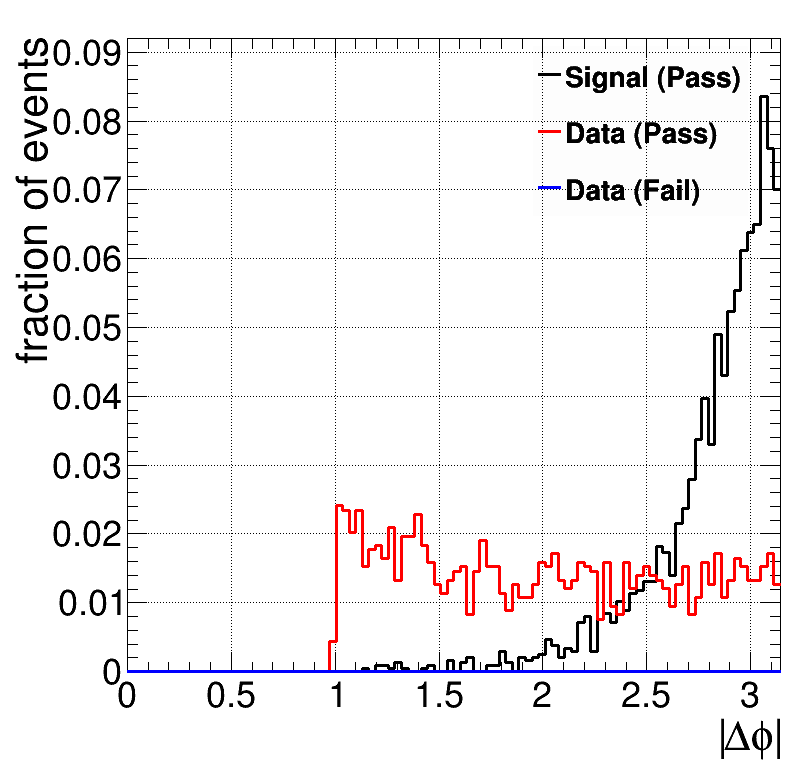

In [228]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

wt = 'weight'

xv = 'tag_dPhi'
txy_label = f';|#Delta#phi|;events'
form =(txy_label,100,0,np.pi)

# **** #

dphi_cut = '1.0 < tag_dPhi'
bump_cut = '(0.55 < tag_dPhi) && (tag_dPhi < 0.8)'
bump_cut = '(0.55 < tag_dPhi) && (tag_dPhi < 0.8) && (tag_dEta < 0.4)'
# bump_cut = 'tag_dR < 1'

better_bcut = '-1 < tag_dPhi'
# better_bcut = '1.0 < tag_dPhi'
# better_bcut = ''
# better_bcut = '(1.0 < tag_dPhi) && (csc1MaxStationRatio < 0.9)'
# better_bcut = '!((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# better_bcut = f'(1.0 < tag_dPhi) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# better_bcut = f'(csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# better_bcut = f'(1.0 < tag_dPhi) && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# # better_bcut = f'{dphi_cut} && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# # better_bcut = f'{dphi_cut} && (csc1MaxStationRatio < 0.9) && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# # Signal 735.1774277009099 events
# # Data 547.0 events
# # better_bcut = f'{dphi_cut} && !((csc1NStation10  == 1) && (csc1AvgStation10 > 2.5))'
# # better_bcut = '!((csc1AvgStation10  == 4) && (csc1MaxStationRatio > 0.7))'

# # better_bcut = 'tag_dEta > 0.5'
# # better_bcut = 'tag_dR > 1.5'#0.9'

# better_bcut = 'tag_dT < 4'
# better_bcut = '(tag_dPhi > 1.0) && (tag_dT < 4)'

# better_bcut = '(csc0AvgStation10 < 2) || (csc1NStation10 > 1.5)'


# **** #

# h1 = rdfs['mc'].Filter(dphi_cut).Histo1D(('Signal',*form),xv,wt).GetValue()
# h2 = rdfs['r3'].Filter(dphi_cut).Histo1D(('Data',*form),xv,wt).GetValue()
# hhs = [h1,h2]

# h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,wt).GetValue()
# h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo1D(('Data (no bump)',*form),xv,wt).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Data (bump)',*form),xv,wt).GetValue()
# hhs = [h1,h2,h3]

h1 = rdfs['mc'].Filter(better_bcut).Histo1D(('Signal (Pass)',*form),xv,wt).GetValue()
h2 = rdfs['r3'].Filter(better_bcut).Histo1D(('Data (Pass)',*form),xv,wt).GetValue()
h3 = rdfs['r3'].Filter(f'!({better_bcut})').Histo1D(('Data (Fail)',*form),xv,wt).GetValue()
hhs = [h1,h2, h3]


hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    print(hh.GetName(), nev, 'events')
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
        hh.GetYaxis().SetTitle('fraction of events')
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()

legend.Draw()
canvas.Draw()


In [214]:
# vars = {str(c):0 for c in rdfs['r3'].GetColumnNames()}
# for v in vars:
#     if v in ('weight','csc0CTau','csc1CTau','dtCTau', 'tag_ctau'):
#         continue
#     rd, rb = rdfs['r3'].Filter(dphi_cut), rdfs['r3'].Filter(bump_cut)
#     dmin, dmax, bmin, bmax = rd.Min(v), rd.Max(v), rb.Min(v), rb.Max(v)
#     dmin, dmax, bmin, bmax = dmin.GetValue(), dmax.GetValue(), bmin.GetValue(), bmax.GetValue()
    
#     # xmin, xmax = min([vs_bump.min(), vs_data.min()]), max([vs_bump.max(), vs_data.max()])
#     # xmin, xmax = max([dmin, bmin]), min([dmax, bmax])
#     xmin, xmax = min([dmin, bmin]), max([dmax, bmax])
#     rd = rdfs['mc']#.Filter(f'({dphi_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
#     # rd = rdfs['r3'].Filter(f'({dphi_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
#     rb = rdfs['r3'].Filter(f'({bump_cut}) && ({xmin} <= {v}) && ({v} <= {xmax})')
#     vs_data = rd.AsNumpy([v])[v].astype(float)
#     vs_bump = rb.AsNumpy([v])[v].astype(float)
#     ndata, nbump = len(vs_data), len(vs_bump)

#     nb_data = int((xmax-xmin)/(2.718*vs_data.std()*ndata**(-1/3))) if vs_data.std()>0 else 5
#     nb_bump = int((xmax-xmin)/(2.718*vs_bump.std()*nbump**(-1/3))) if vs_bump.std()>0 else 5
#     nb = min(nb_data, nb_bump)
#     # print(v, nb, xmin, xmax)

#     hdata = np.histogram(vs_data, nb, (xmin, xmax), density=True)
#     hbump = np.histogram(vs_bump, nb, (xmin, xmax), density=True)

#     rms = np.sum((hdata[0]-hbump[0])**2)**0.5
#     vars[v] = rms
#     print(v, rms)

# print(r'\begin{center}')
# print(r'\begin{tabular}{c|c}')
# print(r'    \hline')
# print(f'    Variable & Histo RMS \\\\')
# print(r'    \hline')
# for k, v in sorted([(k,v) for k, v in vars.items()], key=lambda x: -x[1])[:10]:
#     print(f'    {k.replace("_"," ")} & {v:.2f} \\\\')
# print(r'\end{tabular}')
# print(r'\end{center}')

In [215]:
test_cols = [
    'csc0AvgStation10',
    # 'csc0CTau',
    'csc0Eta',
    'csc0JetVetoE',
    'csc0JetVetoLooseId',
    'csc0JetVetoPt',
    'csc0JetVetoTightId',
    'csc0MaxChamber',
    # 'csc0MaxChamberRatio', # Something is wrong with this variable
    'csc0MaxStation',
    'csc0MaxStationRatio',
    # 'csc0Met_dPhi',
    'csc0MuonVetoE',
    'csc0MuonVetoGlobal',
    'csc0MuonVetoLooseId',
    'csc0MuonVetoPt',
    'csc0NChamber',
    'csc0NRechitChamberMinus11',
    'csc0NRechitChamberMinus12',
    'csc0NRechitChamberMinus13',
    'csc0NRechitChamberMinus21',
    'csc0NRechitChamberMinus22',
    'csc0NRechitChamberMinus31',
    'csc0NRechitChamberMinus32',
    'csc0NRechitChamberMinus41',
    'csc0NRechitChamberMinus42',
    'csc0NRechitChamberPlus11',
    'csc0NRechitChamberPlus12',
    'csc0NRechitChamberPlus13',
    'csc0NRechitChamberPlus21',
    'csc0NRechitChamberPlus22',
    'csc0NRechitChamberPlus31',
    'csc0NRechitChamberPlus32',
    'csc0NRechitChamberPlus41',
    'csc0NRechitChamberPlus42',
    'csc0NStation10',
    'csc0Phi',
    'csc0R',
    'csc0Size',
    # 'csc0Time',
    # 'csc0TimeSpread',
    # 'csc0TimeSpreadWeightedAll',
    # 'csc0TimeWeighted',
    'csc0X',
    'csc0Y',
    'csc0Z',
    # 'csc0_match_MB1Seg_0p4',
    # 'csc0_match_RB1_0p4',
    # 'csc0_match_RE12_0p4',
    # 'csc0_match_dtSeg_0p4',
    #
    'csc1AvgStation10',
    # 'csc1CTau',
    'csc1Eta',
    'csc1JetVetoE',
    'csc1JetVetoLooseId',
    'csc1JetVetoPt',
    'csc1JetVetoTightId',
    'csc1MaxChamber',
    # 'csc1MaxChamberRatio', # Something is wrong with this variable
    'csc1MaxStation',
    'csc1MaxStationRatio',
    # 'csc1Met_dPhi',
    'csc1MuonVetoE',
    'csc1MuonVetoGlobal',
    'csc1MuonVetoLooseId',
    'csc1MuonVetoPt',
    'csc1NChamber',
    'csc1NRechitChamberMinus11',
    'csc1NRechitChamberMinus12',
    'csc1NRechitChamberMinus13',
    'csc1NRechitChamberMinus21',
    'csc1NRechitChamberMinus22',
    'csc1NRechitChamberMinus31',
    'csc1NRechitChamberMinus32',
    'csc1NRechitChamberMinus41',
    'csc1NRechitChamberMinus42',
    'csc1NRechitChamberPlus11',
    'csc1NRechitChamberPlus12',
    'csc1NRechitChamberPlus13',
    'csc1NRechitChamberPlus21',
    'csc1NRechitChamberPlus22',
    'csc1NRechitChamberPlus31',
    'csc1NRechitChamberPlus32',
    'csc1NRechitChamberPlus41',
    'csc1NRechitChamberPlus42',
    'csc1NStation10',
    'csc1Phi',
    'csc1R',
    # 'csc1Size',
    # 'csc1Time',
    # 'csc1TimeSpread',
    # 'csc1TimeSpreadWeightedAll',
    # 'csc1TimeWeighted',
    'csc1X',
    'csc1Y',
    'csc1Z',
    # 'csc1_match_MB1Seg_0p4',
    # 'csc1_match_RB1_0p4',
    # 'csc1_match_RE12_0p4',
    # 'csc1_match_dtSeg_0p4',
    #
    # 'evtNum',
    'met',
    'metPhi',
    'nJets',
    'nLeptons',
    # 'tag_ctau',
    # 'tag_dEta',
    # 'tag_dPhi',
    # 'tag_dR',
    # 'tag_dT',
    # 'tag_size',
    # 'weight'
]

test_cols.append('NOISE')

# **** #

mc_dict = rdfs['mc'].AsNumpy()#
r3_dict = rdfs['r3'].AsNumpy()#

mc_dict['NOISE'] = np.random.randn(mc_dict['weight'].shape[0])
r3_dict['NOISE'] = np.random.randn(r3_dict['weight'].shape[0])

X_mc = np.array([mc_dict[c] for c in test_cols], dtype=float).T
X_r3 = np.array([r3_dict[c] for c in test_cols], dtype=float).T

# **** #

bump_dict = rdfs['r3'].Filter(f'({bump_cut})').AsNumpy()
else_dict = rdfs['r3'].Filter(f'!({bump_cut})').AsNumpy()

bump_dict['NOISE'] = np.random.randn(bump_dict['weight'].shape[0])
else_dict['NOISE'] = np.random.randn(else_dict['weight'].shape[0])

X_bump = np.array([bump_dict[c] for c in test_cols], dtype=float).T
X_else = np.array([else_dict[c] for c in test_cols], dtype=float).T


In [216]:
# from sklearn.ensemble import RandomForestRegressor

# # **** #

# X = np.array([r3_dict[c] for c in test_cols], dtype=float).T
# y = r3_dict['tag_dR']

# # **** #

# rfc = RandomForestRegressor(n_estimators=500, min_samples_leaf=10, max_depth=5, oob_score=True)#, max_features=0.99
# rfc.fit(X, y)

# scores = rfc.feature_importances_
# idxs = np.argsort(scores)[::-1]

# print(f'OOB Score = {rfc.oob_score_}')
# print('')

# for i in idxs:
#     print(test_cols[i], scores[i])

# **************** #

from sklearn.ensemble import RandomForestClassifier

# **** #

X = np.r_[X_mc, X_r3]
y = np.r_[np.ones(len(X_mc)), np.zeros(len(X_r3))]
y_wt = np.r_[np.ones(len(X_mc))/len(X_mc), np.ones(len(X_r3))/len(X_r3)]

# X = np.r_[X_bump, X_else]
# y = np.r_[np.ones(len(X_bump)), np.zeros(len(X_else))]
# y_wt = np.r_[np.ones(len(X_bump))/len(X_bump), np.ones(len(X_else))/len(X_else)]

# **** #

rfc = RandomForestClassifier(n_jobs=-1, n_estimators=500, min_samples_leaf=10, oob_score=True)#, max_features=0.99
rfc.fit(X, y, y_wt)

scores = rfc.feature_importances_
idxs = np.argsort(scores)[::-1]

print(f'OOB Score = {rfc.oob_score_}')
print('')

for i in idxs:
    print(test_cols[i], scores[i])

OOB Score = 0.9011657374556513

csc1MaxStationRatio 0.09480406307373514
csc1R 0.07850175530643491
csc1NStation10 0.06246446195478505
csc0JetVetoPt 0.05660025967915461
csc0Size 0.05473887236899109
csc0MaxStationRatio 0.04924016724024257
csc0JetVetoE 0.04369128714236583
csc0R 0.03398745412988328
csc0MaxChamber 0.031916531340766226
csc0NStation10 0.03028080803186113
csc1JetVetoE 0.027200440107505944
csc0AvgStation10 0.026103687829232225
csc0Z 0.02583632553068868
csc1JetVetoPt 0.025778334754642113
csc1MaxChamber 0.025429704104403827
csc0NRechitChamberMinus12 0.024469703634480956
csc1Eta 0.02378467118740892
csc0NRechitChamberPlus12 0.019103418614835152
csc0MaxStation 0.01526204598668443
csc0Eta 0.014562930438814943
csc1Z 0.013504992989049232
csc0Y 0.011532515924409681
metPhi 0.01145219669084104
csc1Y 0.010709149645151433
csc1X 0.010238444650836625
csc1AvgStation10 0.009670975389145294
csc0Phi 0.008715291430843496
csc0NRechitChamberMinus22 0.008495718468844112
csc0NRechitChamberPlus41 0.0080

In [395]:
from sklearn.tree import DecisionTreeClassifier
from scipy.special import comb

for mult in [1.0,1.1, 1.2, 1.3, 1.4, 1.5, 2, 4, 8]:

    # **** #
    ns = min(len(X_r3),len(X_mc))
    # X = np.abs(np.r_[X_r3[:ns],X_mc[:ns]])
    # y = np.r_[np.zeros(ns),np.ones(ns)]
    # y_wt = np.r_[np.ones(ns)/ns,np.ones(ns)/ns]


    X = np.abs(np.r_[X_r3,X_mc])
    y = np.r_[np.zeros(len(X_r3)),np.ones(len(X_mc))]
    y_wt = np.r_[np.ones(len(X_r3))/len(X_r3),np.ones(len(X_mc))/len(X_mc)*mult]
    # y_wt = np.r_[np.ones(len(X_r3))*ns/len(X_r3),np.ones(len(X_mc))*ns/len(X_mc)]

    # X = np.r_[X_bump, X_else]
    # y = np.r_[np.ones(len(X_bump)), np.zeros(len(X_else))]
    # y_wt = np.r_[np.ones(len(X_bump))/len(X_bump), np.ones(len(X_else))/len(X_else)]

    # **** #

    # pre_indices = [[i,j] 
    #                for i in range(len(test_cols))
    #                for j in range(i+1, len(test_cols))]

    pre_indices = [[i,j,k] 
                for i in range(len(test_cols))
                for j in range(i+1, len(test_cols)) 
                for k in range(j+1, len(test_cols))]

    nfeats = len(pre_indices[0])
    indices = [None]
    scores = []
    trees = []

    print(len(pre_indices))
    # for i in range(len(pre_indices)):
    for i in range(min(50_000,len(pre_indices))):
    # for i in range(min(10_000,len(pre_indices))):
    # for i in range(min(1_000,len(pre_indices))):
        # if i%1000 == 0:
        #     print(i)

        if len(pre_indices) == 0: # i > comb(len(test_cols), nfeats):
            break

        ifts = pre_indices[np.random.randint(len(pre_indices))]
        pre_indices.remove(ifts)
        # ifts = None
        # while ifts in indices:
        #     fts_idxs = [i for i in range(len(test_cols))]
        #     ifts = list(np.random.choice(len(test_cols), nfeats, False))
        #     ifts = sorted(ifts)

        _X = X[:,ifts]

        # dtc = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.1, max_depth=3)
        # dtc = DecisionTreeClassifier(criterion='entropy', max_depth=3)
        dtc = DecisionTreeClassifier(criterion='entropy', min_weight_fraction_leaf=0.1, max_depth=3)
        # dtc = DecisionTreeClassifier(criterion='entropy', min_weight_fraction_leaf=0.1, max_depth=5)
        # dtc = RandomForestClassifier(n_estimators=100, max_features=2, max_depth=1, n_jobs=-1)
        dtc.fit(_X, y, y_wt)

        y_pred = dtc.predict(_X)
        s = np.sum(y[y_pred==1] == 1)
        b = np.sum(y[y_pred==1] == 0)
        s2b = s / (b**0.5) if b else 0

        # scores.append([if1, if2, rfc.oob_score_])
        indices.append(ifts)
        scores.append([dtc.score(_X, y), s2b])# score gives mean accuracy
        trees.append(dtc)
        # print(cols[if1], cols[if2], scores[-1][-1])

        # scores = rfc.feature_importances_
        # idxs = np.argsort(scores)[::-1]

        # print(f'OOB Score = {rfc.oob_score_}')
        # print('')

        # for i in idxs:
        #     print(cols[i], scores[i])
        
    indices.remove(None)
    scores = np.array(scores)
    indices = np.array(indices, dtype=int)

    print(mult, np.max(scores[:,1]))

88560
1.0 130.6537207156463
88560
1.1 130.64308153935426
88560
1.2 130.64308153935426
88560
1.3 130.64308153935426
88560
1.4 127.83199158383302
88560
1.5 127.83199158383302
88560
2 107.3525387103983
88560
4 107.086239482798
88560
8 83.72543474995378


In [ ]:
"""
  0 & 0.923 & 39.5 & csc0JetVetoE & csc0MaxStation & csc0MaxStationRatio
  1 & 0.915 & 36.9 & csc0JetVetoPt & csc0Z & csc1X
  2 & 0.914 & 36.0 & csc0AvgStation10 & csc1JetVetoTightId & csc1X
  3 & 0.914 & 36.0 & csc0AvgStation10 & csc0NRechitChamberPlus11 & csc1X
  4 & 0.914 & 36.0 & csc0AvgStation10 & csc0NStation10 & csc1X
  5 & 0.914 & 36.0 & csc0AvgStation10 & csc1NRechitChamberPlus22 & csc1X
  6 & 0.914 & 36.0 & csc0AvgStation10 & csc1NRechitChamberMinus41 & csc1X
  7 & 0.914 & 36.0 & csc0AvgStation10 & csc1NRechitChamberPlus32 & csc1X
  8 & 0.914 & 36.0 & csc0AvgStation10 & csc0NRechitChamberMinus42 & csc1X
  9 & 0.908 & 35.6 & csc0AvgStation10 & csc0JetVetoE & csc1Y
"""
idxs = np.argsort(scores[:,1])[::-1]
for i, idx in enumerate(idxs[:10]):
    print(f'{i:>3} & {scores[idx,0]:.3f} & {scores[idx,1]:.1f} & '+' & '.join([test_cols[ift] for ift in indices[idx]])+' \\\\')

  0 & 0.735 & 130.6 & csc0AvgStation10 & csc0JetVetoPt & csc0MaxStationRatio \\
  1 & 0.731 & 130.3 & csc0JetVetoPt & csc0MaxStationRatio & csc0Z \\
  2 & 0.772 & 127.4 & csc0JetVetoE & csc0Z & csc1NStation10 \\
  3 & 0.772 & 127.4 & csc0JetVetoPt & csc0Z & csc1NStation10 \\
  4 & 0.734 & 112.4 & csc0AvgStation10 & csc0MaxStation & csc0MaxStationRatio \\
  5 & 0.734 & 112.4 & csc0AvgStation10 & csc0MaxStationRatio & csc1NRechitChamberMinus11 \\
  6 & 0.734 & 112.4 & csc0AvgStation10 & csc0MaxStationRatio & csc0NRechitChamberMinus31 \\
  7 & 0.734 & 112.4 & csc0AvgStation10 & csc0JetVetoTightId & csc0MaxStationRatio \\
  8 & 0.734 & 112.4 & csc0AvgStation10 & csc0MaxStationRatio & csc1NRechitChamberPlus12 \\
  9 & 0.734 & 112.4 & csc0AvgStation10 & csc0MaxStationRatio & NOISE \\


2368 1578 59.61124586614141 0.6001013684744044
2049 517 90.11491696266285 0.7985190958690569


[Text(0.4, 0.9, 'csc0AvgStation10 <= 1.96\nentropy = 1.0\nsamples = 100.0%\nvalue = [0.5, 0.5]\nclass = Data'),
 Text(0.2, 0.7, 'entropy = 0.45\nsamples = 25.2%\nvalue = [0.1, 0.9]\nclass = Signal'),
 Text(0.6, 0.7, 'csc0JetVetoPt <= 10.07\nentropy = 0.96\nsamples = 74.8%\nvalue = [0.61, 0.39]\nclass = Data'),
 Text(0.4, 0.5, 'csc0MaxStationRatio <= 0.91\nentropy = 1.0\nsamples = 53.7%\nvalue = [0.47, 0.53]\nclass = Signal'),
 Text(0.2, 0.3, 'entropy = 0.59\nsamples = 14.5%\nvalue = [0.14, 0.86]\nclass = Signal'),
 Text(0.6, 0.3, 'csc0AvgStation10 <= 2.0\nentropy = 0.99\nsamples = 39.3%\nvalue = [0.57, 0.43]\nclass = Data'),
 Text(0.4, 0.1, 'entropy = 0.89\nsamples = 13.9%\nvalue = [0.69, 0.31]\nclass = Data'),
 Text(0.8, 0.1, 'entropy = 1.0\nsamples = 25.4%\nvalue = [0.49, 0.51]\nclass = Signal'),
 Text(0.8, 0.5, 'entropy = 0.42\nsamples = 21.1%\nvalue = [0.92, 0.08]\nclass = Data')]

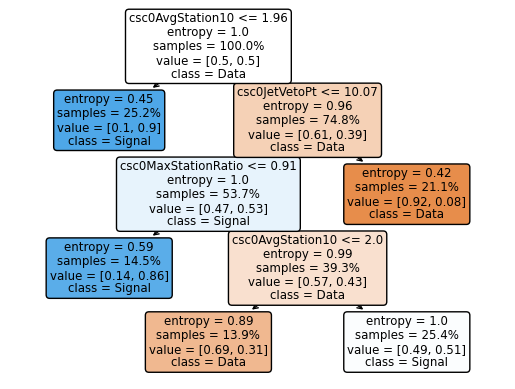

In [ ]:
from sklearn import tree

idx = idxs[0]
_X = X[:,indices[idx]]

# dtc = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.1, max_depth=3, ccp_alpha=0.001)
# dtc = DecisionTreeClassifier(criterion='entropy', min_weight_fraction_leaf=0.1, max_depth=3)#, ccp_alpha=0.01)
dtc = DecisionTreeClassifier(criterion='entropy', min_weight_fraction_leaf=0.1, max_depth=4, ccp_alpha=0.01)
dtc.fit(_X, y, y_wt)
y_pred = dtc.predict(_X)

s0 = np.sum(y==1)
b0 = np.sum(y==0)
s2b0 = s0 / (b0**0.5) if b0 else 0
acc0 = s0 / (s0 + b0)

s = np.sum(y[y_pred==1] == 1)
b = np.sum(y[y_pred==1] == 0)
s2b = s / (b**0.5) if b else 0
acc = s / (s + b)

print(s0, b0, s2b0, acc0)
print(s, b, s2b, acc)

tree.plot_tree(
    dtc,
    # trees[idx],
    feature_names=[test_cols[ift] for ift in indices[idx]],
    class_names=['Data', 'Signal'],
    filled=True,
    proportion=True,
    rounded=True,
    precision=2,
    fontsize=None,
    
)

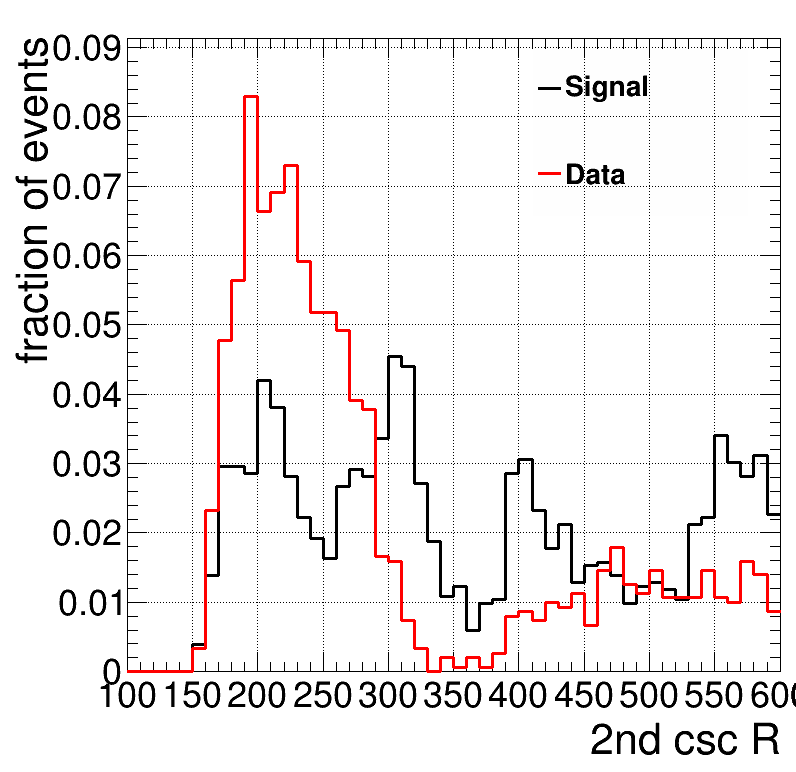

In [379]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.67, 0.72, 0.94, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.15)

# **** #

xv = 'csc0Met_dPhi'
txy_label = f';csc0Met_dPhi;fraction of events'
form =(txy_label,20,0,np.pi)

xv = 'csc0TimeWeighted'
txy_label = f';csc0TimeWeighted;fraction of events'
form =(txy_label,25,-10,15)

# xv = 'csc0Z'
# txy_label = f';Trigger CSC Z Position [cm];fraction of events'
# form =(txy_label,50,500,1100)

# xv = 'csc0Phi'
# txy_label = f';csc0Phi;fraction of events'
# form =(txy_label,10,-np.pi,np.pi)

# xv = 'csc1Phi'
# txy_label = f';csc1Phi;fraction of events'
# form =(txy_label,10,-np.pi,np.pi)

# xv = 'csc0MaxChamber'
# txy_label = f';csc0MaxChamber;fraction of events'
# form =(txy_label,32,0,10000)

# xv = 'csc0MaxStationRatio'
# txy_label = f';csc0MaxStationRatio;fraction of events'
# form =(txy_label,10,0,1)

# xv = 'csc1MaxStationRatio'
# txy_label = f';csc1MaxStationRatio;fraction of events'
# form =(txy_label,10,0,1)

# xv = 'csc1NStation10'
# txy_label = f';csc1NStation10;fraction of events'
# form =(txy_label,20,0,10)

xv = 'csc1R'
txy_label = f';2nd csc R;fraction of events'
form =(txy_label,50,100,600)

# # xv = 'csc1TimeSpreadWeightedAll'
# # txy_label = f';csc1TimeSpreadWeightedAll;fraction of events'
# # form =(txy_label,50,0,20)

# # xv = 'csc0JetVetoLooseId'
# # txy_label = f';csc0JetVetoLooseID;fraction of events'
# # form =(txy_label,50,0,20)

# xv = 'csc0MaxChamberRatio'
# txy_label = f';csc0MaxChamberRatio;fraction of events'
# form =(txy_label,100,0,1)

# xv = 'csc1MaxChamberRatio'
# txy_label = f';csc1MaxChamberRatio;fraction of events'
# form =(txy_label,100,0,19879599.5)

# xv = 'tag_dEta'
# txy_label = f';#Delta#eta;fraction of events'
# form =(txy_label,100,0,5)

# xv = 'tag_dR'
# txy_label = f';#DeltaR;fraction of events'
# form =(txy_label,100,0,5)

# xv = 'tag_dT'
# txy_label = f';tag_dT;fraction of events'
# form =(txy_label,50,0,20)
# form =(txy_label,80,-20,20)


# **** #

h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
h2 = rdfs['r3'].Histo1D(('Data',*form),xv,).GetValue()
hhs = [h1,h2]

# h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
# h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo1D(('Data w/o bump',*form),xv,).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo1D(('Bump',*form),xv,).GetValue()
# hhs = [h1,h2,h3]


# hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
for ih, hh in enumerate(hhs):
    nev = hh.Integral()
    if hmax < 1 and nev:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    hh.Draw('hist same')
    legend.AddEntry(hh, hh.GetName(), 'L')

# l = TLine(1.0,0,1.0,hmax*1.1)
# l.SetLineColor(rt.kMagenta)
# l.SetLineWidth(3)
# l.Draw()

legend.Draw()
canvas.Draw()


1199.0
820.0


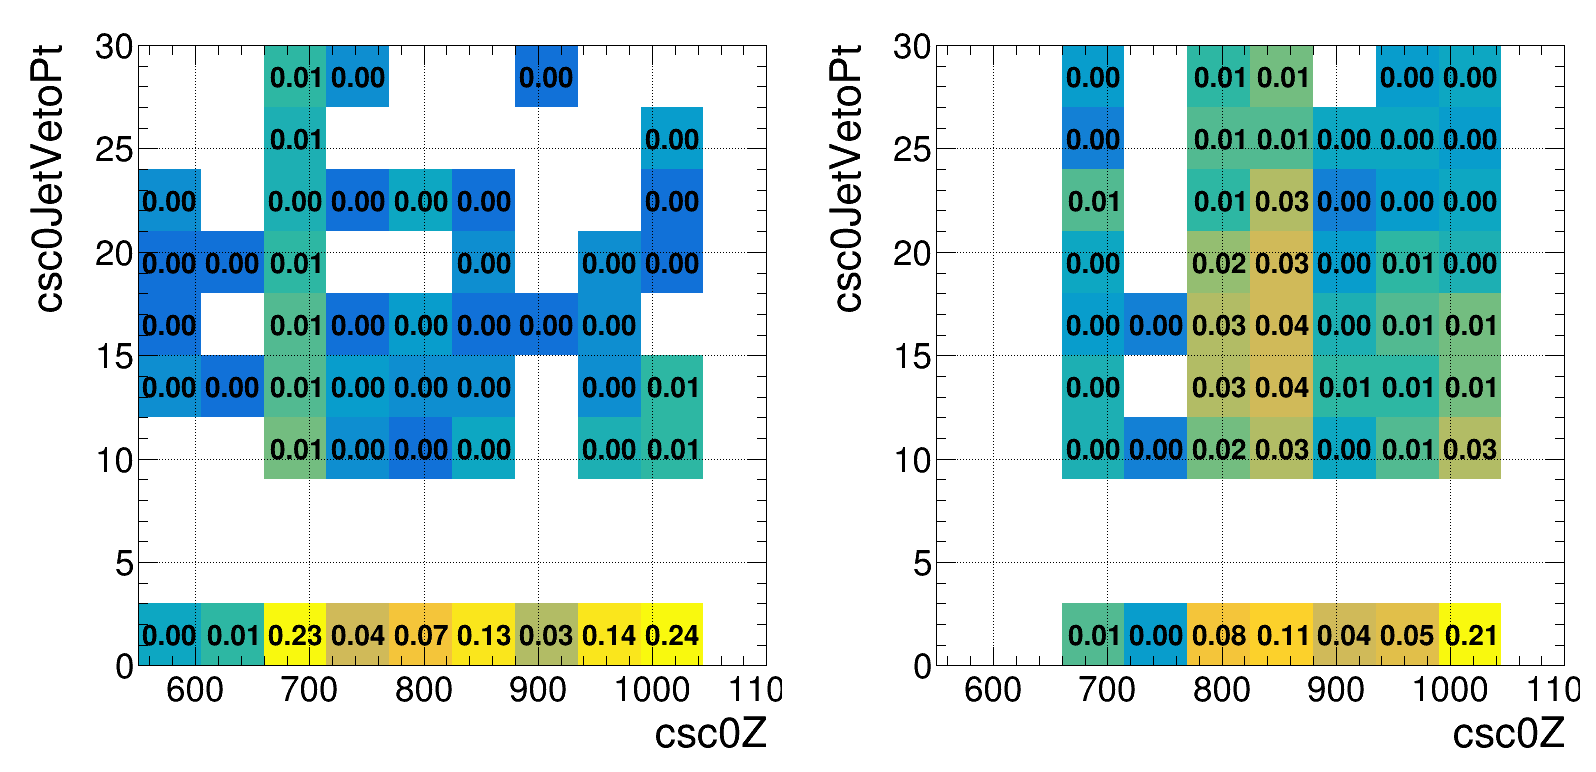

In [267]:
# **** #
 
# nb = 20
# xv, yv = 'csc1Time', 'csc0TimeSpread'
# txy_label = f';csc1Time;csc0TimeSpread;fraction of events'
# bins = (nb, -10, 10, nb, 0, 30)
# logxyz = (False, False, False)

# nb = 20
# xv, yv = 'csc0TimeWeighted', 'csc0TimeSpread'
# txy_label = f';csc0TimeWeighted;csc0TimeSpread;fraction of events'
# bins = (nb, -10, 10, nb, 0, 30)
# logxyz = (False, False, False)

# nb = 20
# xv, yv = 'csc0Phi', 'csc1Phi'
# txy_label = f';1st csc phi;2nd csc phi;fraction of events'
# bins = (nb, 0, np.pi, nb, 0, np.pi)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0Phi', 'tag_dEta'
# txy_label = f';1st csc phi;#Delta#eta;fraction of events'
# bins = (nb, 0, np.pi, nb, 0, 5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc1Phi', 'tag_dEta'
# txy_label = f';2nd csc phi;#Delta#eta;fraction of events'
# bins = (nb, 0, np.pi, nb, 0, 5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0Phi', 'csc0R'
# txy_label = f';1st csc phi;1st csc R;fraction of events'
# bins = (nb, 0, np.pi, nb, 100, 700)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc1Phi', 'csc1R'
# txy_label = f';2nd csc phi;2nd csc R;fraction of events'
# bins = (nb, 0, np.pi, nb, 100, 700)
# logxyz = (False, False, True)

# nb = 50
# xv, yv = 'csc1R', 'tag_dEta'
# txy_label = f';2nd csc R;#Delta#eta;fraction of events'
# bins = (nb, 100, 700, nb, 0, 1.5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc0R', 'csc1R'
# txy_label = f';1st csc R;2nd csc R;fraction of events'
# bins = (nb, 100, 700, nb, 100, 700)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'csc0MaxStationRatio', 'csc1R'
# txy_label = f';csc0MaxStationRatio;csc1R;fraction of events'
# bins = (10, 0, 1, 10, 100, 700)
# logxyz = (False, False, False)


# nb = 20
# xv, yv = 'csc0Z', 'csc0R'
# txy_label = f';csc0Z;csc0R;fraction of events'
# bins = (nb, 400, 1100, nb, 100, 700)
# logxyz = (False, False, False)

# nb = 25
# xv, yv = 'csc0Z', 'csc1NStation10'
# txy_label = f';csc0Z;csc1NStation10;fraction of events'
# bins = (nb, 550, 1100, 4, 0.5, 4.5)
# logxyz = (False, False, True)

# nb = 25
# xv, yv = 'csc0Z', 'csc1MaxChamberRatio'
# txy_label = f';csc0Z;csc1MaxChamberRatio;fraction of events'
# bins = (nb, 550, 1100, 10, 0, 1)
# logxyz = (False, False, True)

nb = 20
xv, yv = 'csc0Z', 'csc0JetVetoPt'
txy_label = f';csc0Z;csc0JetVetoPt;fraction of events'
bins = (10, 550, 1100, 10, 0, 30)
logxyz = (False, False, True)

# nb = 20
# xv, yv = 'csc1Z', 'csc1R'
# txy_label = f';csc1Z;csc1R;fraction of events'
# bins = (nb, 400, 1100, nb, 100, 700)
# logxyz = (False, False, False)

# nb = 20
# xv, yv = 'csc0MaxStationRatio', 'csc1MaxStationRatio'
# txy_label = f';csc0MaxStationRatio;csc1MaxStationRatio;fraction of events'
# bins = (nb, 0, 1, nb, 0, 1)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'csc1MaxStationRatio'
# txy_label = f';tag_dEta;csc1MaxStationRatio;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1)
# logxyz = (False, False, True)


# nb = 10
# xv, yv = 'csc0Time', 'csc1MaxChamberRatio'
# txy_label = f';csc0Time;csc1MaxChamberRatio;fraction of events'
# bins = (nb, -5, 15, nb, 0, 1)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'csc0Eta', 'tag_dEta'
# txy_label = f';csc0Eta;tag_dEta;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1.5)
# logxyz = (False, False, True)


# nb = 20
# xv, yv = 'tag_dR', 'tag_dEta'
# txy_label = f';tag_dR;tag_dEta;fraction of events'
# bins = (nb, 0, 5, nb, 0, 1)
# bins = (nb, 0, 1.5, nb, 0, 1.5)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'tag_size'
# txy_label = f';tag_dEta;tag_size;fraction of events'
# bins = (nb, 0, 1.5, nb, 50, 100)
# logxyz = (False, False, True)

# nb = 20
# xv, yv = 'tag_dEta', 'tag_dT'
# txy_label = f';tag_dEta;tag_dT;fraction of events'
# bins = (nb, 0, 1.5, nb, 0, 4)
# logxyz = (False, False, False)


# nb = 10
# xv, yv = 'csc1NStation10', 'csc1MaxStationRatio'
# txy_label = f';csc1NStation10;csc1MaxStationRatio;fraction of events'
# bins = (6, -0.5, 5.5, nb, 0, 1)
# logxyz = (False, False, False)


# nb = 10
# xv, yv = 'csc1AvgStation10', 'csc1MaxStation'
# txy_label = f';csc1AvgStation10;csc1MaxStation;fraction of events'
# bins = (6, -0.5, 5.5, 6, -0.5, 5.5)
# logxyz = (False, False, False)

# nb = 10
# xv, yv = 'csc1NStation10', 'csc1AvgStation10'
# txy_label = f';csc1NStation10;csc1AvgStation10;fraction of events'
# bins = (6, -0.5, 5.5, 6, -0.5, 5.5)
# logxyz = (False, False, False)

# nb = 10
# xv, yv = 'csc0AvgStation10', 'csc0MaxStationRatio'
# txy_label = f';csc0AvgStation10;csc0MaxStationRatio;fraction of events'
# bins = (6, -0.5, 5.5, nb, 0, 1)
# logxyz = (False, False, True)

# nb = 10
# xv, yv = 'csc0AvgStation10', 'csc0JetVetoPt'
# txy_label = f';csc0AvgStation10;csc0JetVetoPt;fraction of events'
# bins = (7, 1, 4.5, 15, 0, 30)
# logxyz = (False, False, True)


# nb = 10
# xv, yv = 'csc0AvgStation10', 'csc1NStation10'
# txy_label = f';csc0AvgStation10;csc1NStation10;fraction of events'
# bins = (8, 0.5, 4.5, 4, 0.5, 4.5)
# logxyz = (False, False, False)

# nb = 25
# xv, yv = 'csc0AvgStation10', 'csc1MaxChamberRatio'
# txy_label = f';csc0AvgStation10;csc1MaxChamberRatio;fraction of events'
# bins = (4, 0.5, 4.5, 10, 0, 10)
# logxyz = (False, False, True)

# **** #


# h1 = rdfs['mc'].Filter('(csc0AvgStation10 < 2) || (csc1NStation10 > 1.5)').Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
# h2 = rdfs['r3'].Filter('(csc0AvgStation10 < 2) || (csc1NStation10 > 1.5)').Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()
# hhs = [h1,h2]

h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
h2 = rdfs['r3'].Histo2D(('Data',txy_label,*bins),xv,yv).GetValue()
hhs = [h1,h2]

# h1 = rdfs['mc'].Histo2D(('Signal',txy_label,*bins),xv,yv).GetValue()
# h2 = rdfs['r3'].Filter(f'!({bump_cut})').Histo2D(('Data w/o Bump',txy_label,*bins),xv,yv).GetValue()
# h3 = rdfs['r3'].Filter(bump_cut).Histo2D(('Bump',txy_label,*bins),xv,yv).GetValue()
# hhs = [h1,h2,h3]

# **** #

canvas = TCanvas('','',len(hhs)*800,800)
canvas.Divide(len(hhs),1)


# **** #
rt.gStyle.SetPaintTextFormat('4.2f')

hmax = max([h.GetMaximum() for h in hhs])
hmax = max([h.GetMaximum() / h.Integral() for h in hhs])
for ih, hh in enumerate(hhs):
    canvas.cd(ih + 1).SetGrid()
    if logxyz[0]:
        canvas.cd(ih + 1).SetLogx()
    if logxyz[1]:
        canvas.cd(ih + 1).SetLogy()
    if logxyz[2]:
        canvas.cd(ih + 1).SetLogz()
    
    print(hh.Integral())
    if hmax <= 1:
        hh.Scale(1/hh.Integral())
    hh.SetMinimum(0)
    hh.SetMaximum(hmax*1.1)
    hh.SetLineColor(SCL[ih])
    hh.SetLineWidth(3)
    # if ih:
    #     hh.Divide(h1)
    hh.Draw('col text')
    hh.SetMarkerSize(2)
    # hh.Draw('col')



# legend.Draw()
canvas.Draw()
